Setting up Kaggle Datasets

In [ ]:
from google.colab import files
files.upload()
!pwd
!ls ./

Saving kaggle.json to kaggle.json
/content
kaggle.json  sample_data


In [ ]:
!rm -rf ~/.kaggle
!mkdir -p ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download rhtsingh/130k-images-512x512-universal-image-embeddings

100% 12.9G/12.9G [11:23<00:00, 21.8MB/s]
100% 12.9G/12.9G [11:23<00:00, 20.4MB/s]


In [ ]:
!mkdir -p data/
!unzip -q 130k-images-512x512-universal-image-embeddings.zip -d data/
!rm 130k-images-512x512-universal-image-embeddings.zip

# Setting up project

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

from fastai import *
from fastai.vision import *
from fastai.vision.all import *

import gc
from tqdm.auto import *
from IPython.display import clear_output

In [ ]:
def optimal_device():
    print("Checking for CUDA availability")
    if torch.cuda.is_available():
        print("CUDA is available")
        return torch.device('cuda')
    else:
        print("CUDA is NOT available")
        try:
            dev = torch.device('mps')
            print("Fallbacking to to use MPS")
            return dev
        except Exception as _:
            print("Fallbacking to CPU")
            return torch.device('cpu')


In [ ]:
device = optimal_device()
selected_dtype = torch.float32

Checking for CUDA availability
CUDA is available


# Model definition

In [ ]:
from functools import reduce
import torch
import torch.nn as nn
import torchvision

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """
    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x
    
class UpBlock(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, up_x):
        x = self.upsample(up_x)
        x = self.conv_block(x)
        return x


class ResNet50Autoencoder(nn.Module):
    def __init__(self, latent_channels=2048, float_type=selected_dtype):
        super().__init__()

        self.float_type = float_type

        resnet = torchvision.models.resnet.resnet50(weights='ResNet50_Weights.DEFAULT')
        down_blocks = []
        up_blocks = []

        self.input_block = nn.Sequential(*list(resnet.children()))[:3] # Conv2D, BatchNorm2D, ReLU
        self.input_pool = list(resnet.children())[3]

        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)

        self.down_blocks = nn.ModuleList(down_blocks)
        
        self.to_latent = ConvBlock(2048, latent_channels)


        self.from_latent = ConvBlock(latent_channels, 2048)

        up_blocks.append(UpBlock(2048, 1024, upsampling_method="bilinear"))
        up_blocks.append(UpBlock(1024, 512, upsampling_method="bilinear"))
        up_blocks.append(UpBlock(512, 256, upsampling_method="bilinear"))
        up_blocks.append(UpBlock(in_channels=256, #128 + 64,
                                 out_channels=128,
                                 up_conv_in_channels=256,
                                 up_conv_out_channels=128, 
                                 upsampling_method="bilinear"))
        up_blocks.append(UpBlock(in_channels=128, #64 + 3,
                                 out_channels=64,
                                 up_conv_in_channels=128,
                                 up_conv_out_channels=64,
                                 upsampling_method="bilinear"))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, 3, kernel_size=1, stride=1)

        self.to(self.float_type)
        
    def encode(self, x):
        x = x.to(self.float_type)
        
        x = self.input_block(x)
        x = self.input_pool(x)

        for _, block in enumerate(self.down_blocks, 2):
            x = block(x)

        x = self.to_latent(x)

        x = torch.sigmoid(x)

#         total = reduce((lambda x, y: x * y), x.shape[1:])
        
#         print(f"Shape: {x.shape} Total: {total}")

        return x
        
    def decode(self, x):
        x = self.from_latent(x)

        for _, block in enumerate(self.up_blocks, 1):
            x = block(x)

        x = self.out(x)
        
        x = torch.sigmoid(x)

        return x

In [ ]:
class Quantization:
    pass

In [ ]:
class NormNoiseQuantization(nn.Module, Quantization):
    def __init__(self, quants: int = 2):
        super().__init__()
        self.quants = quants

    def forward(self, x):
        x = x + ((torch.rand_like(x, requires_grad=True) - 0.5) / (2 ** self.quants))
        return x

In [ ]:
class DigitQuantization(nn.Module, Quantization):
    def __init__(self, quants: int = 2, orig_type = selected_dtype, q_type = torch.int8):
        super().__init__()
        self.quants = quants
        self.orig_type = orig_type
        self.q_type = q_type

    def forward(self, x):
        return torch.round(x.detach() * (2 ** self.quants) + 0.5).to(self.q_type)
    
    def backward(self, x):
        return x.to(self.orig_type) / (2 ** self.quants)

In [ ]:
class GumbelSoftmaxQuantizer(nn.Module):
    def __init__(self, num_levels, temperature):
        super().__init__()
        self.num_levels = num_levels
        self.temperature = temperature

    def forward(self, z):
        z = F.gumbel_softmax(z, tau=self.temperature, hard=True)
        z_q = torch.round(z * (self.num_levels - 1))  # quantize to the range [0, num_levels - 1]
        return z_q

quantizer = GumbelSoftmaxQuantizer(num_levels=256, temperature=1.0)
z_q = quantizer(z)


In [ ]:
# quantization = NormNoiseQuantization(2)

# model = ResNet50Autoencoder(1024, float_type=torch.float32).to(device)
# inp = torch.rand((2, 3, 512, 512)).to(device)

# latent = model.encode(inp)

# quantized = quantization(latent)

# out = model.decode(quantized)

# Dataset loader

In [ ]:
folder = "data/"
w_folder = "data/"
path_data = pd.read_csv(f"{folder}/train.csv")
print("Was")
print(path_data.head(5))
path_data['path'] = path_data['label'] + "/" + path_data['image_name']
path_data = path_data.drop(['image_name'], axis=1).reindex(columns=['path', 'label'])
# path_data = path_data.sample(1000)
# path_data = path_data.iloc[:1000]
path_data.to_csv(f"{w_folder}/labels.csv", index=False)
print("Modified")
print(path_data.head(5))
del(path_data)

Was
      image_name    label
0  image0000.jpg  apparel
1  image0001.jpg  apparel
2  image0002.jpg  apparel
3  image0003.jpg  apparel
4  image0004.jpg  apparel
Modified
                    path    label
0  apparel/image0000.jpg  apparel
1  apparel/image0001.jpg  apparel
2  apparel/image0002.jpg  apparel
3  apparel/image0003.jpg  apparel
4  apparel/image0004.jpg  apparel


In [ ]:
dataloader = ImageDataLoaders.from_csv(
    f"{folder}/", csv_fname=f"labels.csv", bs = 64,
    valid_pct=0.2, shuffle=True, dtype=selected_dtype, batch_tfms=[
        *aug_transforms(size=224, min_scale=0.75) #, Normalize.from_stats(*imagenet_stats)
    ])

# Loss Functions

In [ ]:
# MSE
def mse_loss(result, target):
    result = result.view(result.size(0), -1)
    target = target.view(target.size(0), -1)
    mses = F.mse_loss(result, target, reduction='none').mean(dim=1)
    return torch.mean(mses)

# PSNR
def psnr(result, target):
    result = result.view(result.size(0), -1)
    maxes = torch.max(result, dim = 1)[0] ** 2
    target = target.view(target.size(0), -1)
    mses = F.mse_loss(result, target, reduction='none').mean(dim=1)
    psnrs = 10.0 * torch.log10(maxes.to(torch.float32) / mses.to(torch.float32)).to(selected_dtype)
    return torch.mean(psnrs)

# # Intermediate vector entropy
# def latent_entropy_aprox(result):
#     result = result.to(torch.float32)
#     probabilities = F.softmax(result, dim=0)
#     entropy = F.cross_entropy(probabilities, torch.ones_like(probabilities) / probabilities.size(0))
#     return entropy.to(selected_dtype)
# Intermediate vector entropy

def latent_entropy_aprox(result):
    unique, counts = torch.unique(result, return_counts=True)
    probabilities = counts.float() / result.numel()
    entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-9))  # Add a small constant for numerical stability
    return entropy.to(selected_dtype)

# Perseptual loss
class VGGFeatures(nn.Module):
    def __init__(self, feature_layers = {3, 6, 11, 16}):
        super(VGGFeatures, self).__init__()
        vgg = torchvision.models.vgg11(weights="VGG11_Weights.DEFAULT")
        vgg.eval()
        for param in vgg.parameters():
            param.requires_grad = False

        self.vgg = vgg
        self.feature_layers = feature_layers

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.vgg.features):
            x = layer(x)
            if i in self.feature_layers:
                features.append(x)
        return features

vgg_features = VGGFeatures().to(device)
def vgg_perceptual_loss(result, target, vgg_to_use=vgg_features):
    result = vgg_to_use(result)
    target = vgg_to_use(target)
    return sum(F.mse_loss(orig, decomp) for orig, decomp in zip(result, target))

# Example
# mse_loss(out, inp), psnr(out, inp), latent_entropy_aprox(quantized), vgg_perceptual_loss(out, inp)

In [ ]:
gc.collect()

77

# Train loop

# Empirical coefs for loss:
mse = 900
psnr = 1
perceptual = 17
entropy = 2

In [39]:
def save_model(model: ResNet50Autoencoder, path: str, prefix: str, offset: int, epoch: int, loss: float, optimizer):
    model = model.to(torch.device('cpu'))
    optimizer = optimizer.to(torch.device('cpu'))
    loss_repr = str(loss).replace(".", ",")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'loss': loss,
        'optimizer_state_dict': optimizer.state_dict()
    }, f"{path}/{prefix}_model_{offset + epoch}_l_{loss_repr}.pth")

def validate(model: ResNet50Autoencoder, valid_quantization: Quantization, dataloader: DataLoader, to_log: bool = True):
    mse_losses = []
    psnr_losses = []
    latent_entropies = []
    vgg_perceptual_losses = []
    
    model.eval()
    
    for i, (batch, _) in tqdm(enumerate(dataloader.valid), total=len(dataloader.valid), desc="Validation"):
        batch = batch.to(selected_dtype).detach()
        
        latent = model.encode(batch)
        quantized = valid_quantization.forward(latent)
        dequantized = valid_quantization.backward(quantized)
        out = model.decode(dequantized)

        if i == 0 and to_log:
            original_1 = batch[0].detach().cpu()
            decompressed_1 = out[0].detach().cpu()
            original_2 = batch[1].detach().cpu()
            decompressed_2 = out[1].detach().cpu()
            
            print("Validation comparisson:")
            
            _, axs = plt.subplots(1, 4, figsize=(12, 3))

            axs[0].imshow(original_1.permute(1, 2, 0).numpy())
            axs[0].set_title("Original")
            axs[1].imshow(decompressed_1.permute(1, 2, 0).numpy())
            axs[1].set_title("Decompressed")
            
            axs[2].imshow(original_2.permute(1, 2, 0).numpy())
            axs[2].set_title("Original")
            axs[3].imshow(decompressed_2.permute(1, 2, 0).numpy())
            axs[3].set_title("Decompressed")
            
            plt.show()
        
        mse_losses.append(mse_loss(out, batch).detach().cpu().numpy())
        psnr_losses.append(psnr(out, batch).detach().cpu().numpy())
        latent_entropies.append(latent_entropy_aprox(quantized).detach().cpu().numpy())
        vgg_perceptual_losses.append(vgg_perceptual_loss(out, batch).detach().cpu().numpy())

    return (sum(mse_losses) / len(mse_losses),
            sum(psnr_losses) / len(psnr_losses),
            sum(latent_entropies) / len(latent_entropies),
            sum(vgg_perceptual_losses) / len(vgg_perceptual_losses))


mse_coef = 100
psnr_coef = -1
perceptual_coef = 20
entropy_coef = -1
log_every_n_epoch = 1

def train_loop(model: ResNet50Autoencoder,
               train_quantization: Quantization,
               valid_quantization: Quantization,
               offset: int,
               epochs: int,
               dataloader: DataLoader,
               optimizer):
               
    mse_losses = []
    psnr_losses = []
    latent_entropies = []
    vgg_perceptual_losses = []
    
    # Pre validation
    v_mse, v_psnr, v_entropy, v_perceptual = validate(model, valid_quantization, dataloader)
    print(f"PRE Validation: MSE: {v_mse}, PSNR: {v_psnr}, Entropy: {v_entropy}, Perceptual: {v_perceptual}")
    
    started_time = time.time()
    
    for epoch in range(epochs):
        # Resource management
        collected = gc.collect()
        print(f"Trashed {collected} objects")

        
        print(f"Epoch {epoch + 1} of {epochs}. Total time: {time.time() - started_time}")
        
        model.train()

        to_log = epoch % log_every_n_epoch == 0
        if (to_log):
          clear_output(wait=True)
        
        # Epoch Train loop
        for i, (batch, _) in tqdm(enumerate(dataloader.train), total=len(dataloader.train), desc="Training"):
            batch = batch.to(selected_dtype)
            
            optimizer.zero_grad()
            
            latent = model.encode(batch)
            quantized = train_quantization(latent)
            out = model.decode(quantized)
            
            mse_l = mse_loss(out, batch)
            psnr_l = psnr(out, batch)
            l_entrop_l = latent_entropy_aprox(quantized)
            percept_l = vgg_perceptual_loss(out, batch)
            
            loss = mse_l * mse_coef + psnr_l * psnr_coef  + percept_l * perceptual_coef + l_entrop_l * entropy_coef
            loss.backward()
            optimizer.step()

            mse_t = mse_l.detach()
            psnr_t = psnr_l.detach()
            l_entrop_t = l_entrop_l.detach()
            percept_t = percept_l.detach()
            
            if i == len(dataloader.train) - 1 and to_log:
                original_1 = batch[0].detach().cpu()
                decompressed_1 = out[0].detach().cpu()
                original_2 = batch[1].detach().cpu()
                decompressed_2 = out[1].detach().cpu()

                print("Train comparisson:")

                _, axs = plt.subplots(1, 4, figsize=(12, 3))

                axs[0].imshow(original_1.permute(1, 2, 0).numpy())
                axs[0].set_title("Original")
                axs[1].imshow(decompressed_1.permute(1, 2, 0).numpy())
                axs[1].set_title("Train Decompressed")

                axs[2].imshow(original_2.permute(1, 2, 0).numpy())
                axs[2].set_title("Original")
                axs[3].imshow(decompressed_2.permute(1, 2, 0).numpy())
                axs[3].set_title("Train Decompressed")

                plt.show()

            mse_losses.append(mse_t.cpu().numpy())
            psnr_losses.append(psnr_t.cpu().numpy())
            latent_entropies.append(l_entrop_t.cpu().numpy())
            vgg_perceptual_losses.append(percept_t.cpu().numpy())

        if to_log:
          # Print losses
          _, axs = plt.subplots(1, 4, figsize=(16, 2))
          
          if len(mse_losses) > 2000:
              mse_losses = mse_losses[::2]
              psnr_losses = psnr_losses[::2]
              latent_entropies = latent_entropies[::2]
              vgg_perceptual_losses = vgg_perceptual_losses[::2]
              
          
          for axis in axs:
              axis.clear()
              axis.grid(True)
              axis.set_xlabel(f'# Batches (bs: {dataloader.bs})')
              axis.set_ylabel('Loss')
              axis.axhline(0, color='black', lw=1)
              axis.axvline(0, color='black', lw=1)

          # plot mse_losses on the first subplot
          axs[0].plot(mse_losses)
          axs[0].scatter(len(mse_losses) - 1, mse_losses[-1], color='red')
          axs[0].set_title('MSE Loss')

          # plot psnr_losses on the second subplot
          axs[1].plot(psnr_losses)
          axs[1].scatter(len(psnr_losses) - 1, psnr_losses[-1], color='red')
          axs[1].set_title('PSNR Loss')

          # plot latent_entropies on the third subplot
          axs[2].plot(latent_entropies)
          axs[2].scatter(len(latent_entropies) - 1, latent_entropies[-1], color='red')
          axs[2].set_title('Latent Entropy')

          # plot vgg_perceptual_losses on the fourth subplot
          axs[3].plot(vgg_perceptual_losses)
          axs[3].scatter(len(vgg_perceptual_losses) - 1, vgg_perceptual_losses[-1], color='red')
          axs[3].set_title('VGG Perceptual Loss')

          # adjust the spacing between subplots
          plt.subplots_adjust(hspace=0.5)

          # show the plot
          plt.show()


        # Validation
        v_mse, v_psnr, v_entropy, v_perceptual = validate(model, valid_quantization, dataloader, to_log)
        print(f"Validation: MSE: {v_mse}, PSNR: {v_psnr}, Entropy: {v_entropy}, Perceptual: {v_perceptual}")

        # Save model
#         !mkdir -p /kaggle/working/weights
#         save_model(model, "/kaggle/working/weights", "L4_resnet50", offset, epoch, v_mse, optimizer)
        

In [ ]:
model = ResNet50Autoencoder(1024, float_type=selected_dtype).to(device)

train_quantization = NormNoiseQuantization(8).to(device)

valid_quantization = DigitQuantization(8, orig_type=selected_dtype, q_type=torch.int32).to(device)

from torch.optim import Adam

adam_optim = Adam(model.parameters(), lr=1e-3)

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


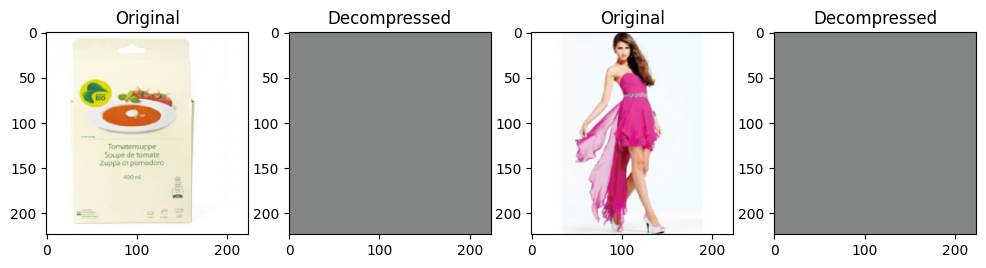

PRE Validation: MSE: 0.10196289840232894, PSNR: 4.839791698915413, Entropy: 3.754542269189674, Perceptual: 2.734611627279994
Trashed 11122 objects
Epoch 1 of 5. Total time: 0.14958620071411133


Training:   0%|          | 0/1656 [00:00<?, ?it/s]

Train comparisson:


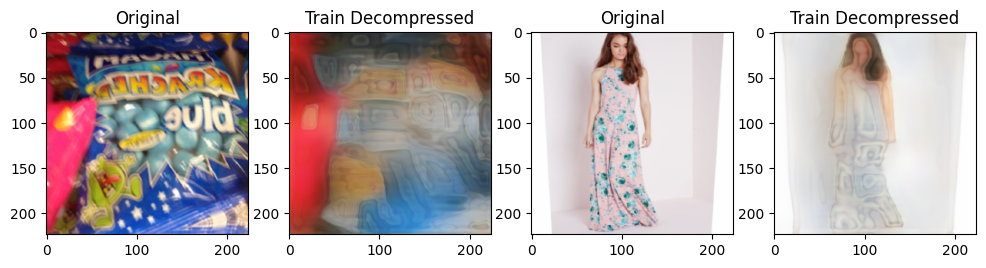

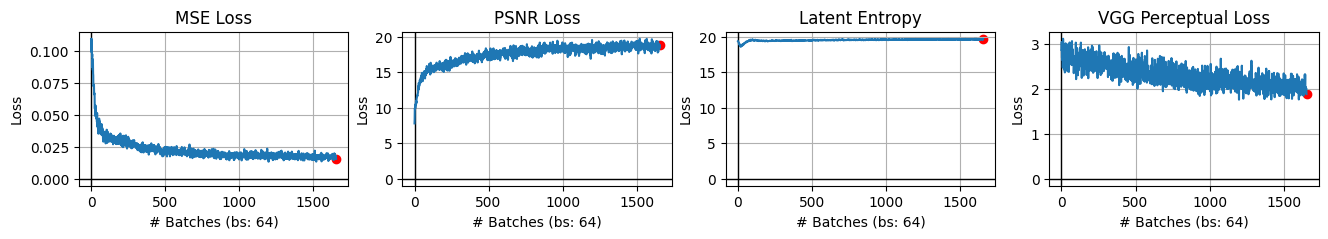

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


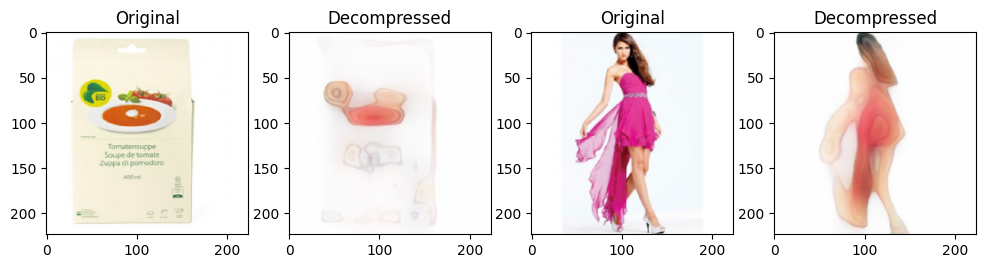

Validation: MSE: 0.019388640294951128, PSNR: 17.88393651663539, Entropy: 4.77601627671575, Perceptual: 2.1069920651883964
Trashed 11111 objects
Epoch 2 of 5. Total time: 870.7362408638


Training:   0%|          | 0/1656 [00:00<?, ?it/s]

Train comparisson:


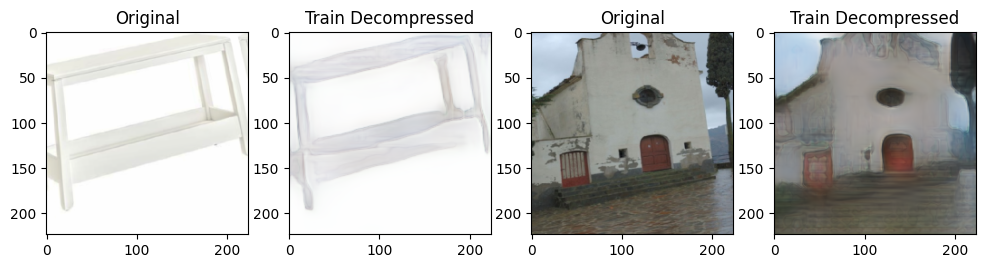

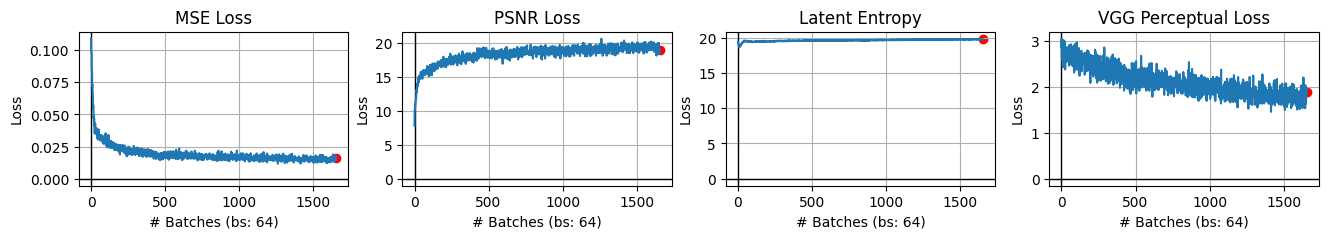

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


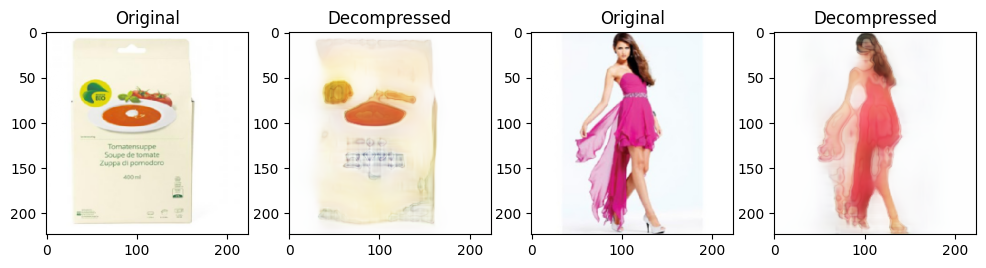

Validation: MSE: 0.015531231402363404, PSNR: 19.051818250173547, Entropy: 4.9838394486760516, Perceptual: 1.772540999033365
Trashed 35115 objects
Epoch 3 of 5. Total time: 1741.3237590789795


Training:   0%|          | 0/1656 [00:00<?, ?it/s]

Train comparisson:


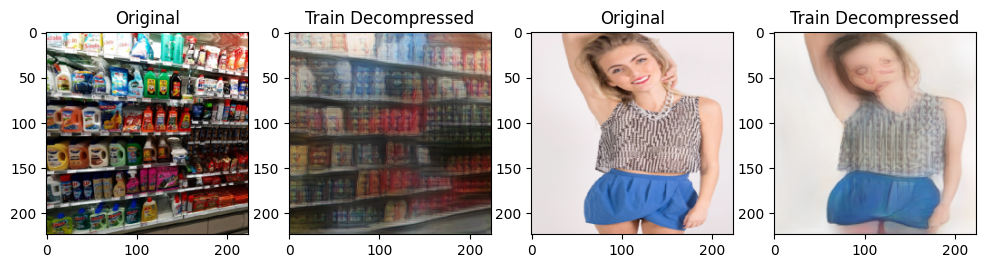

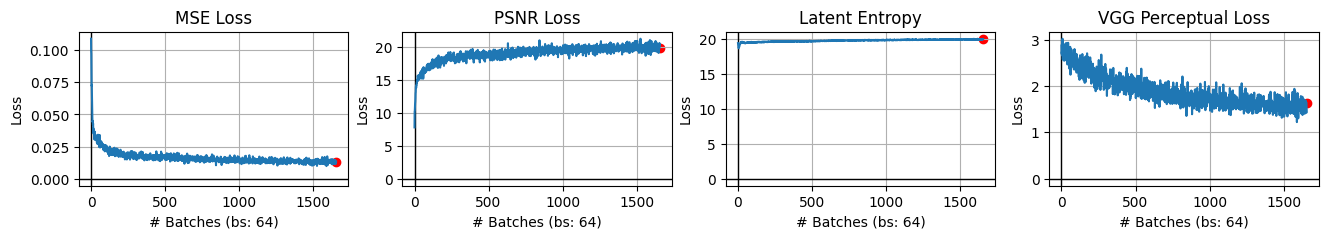

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


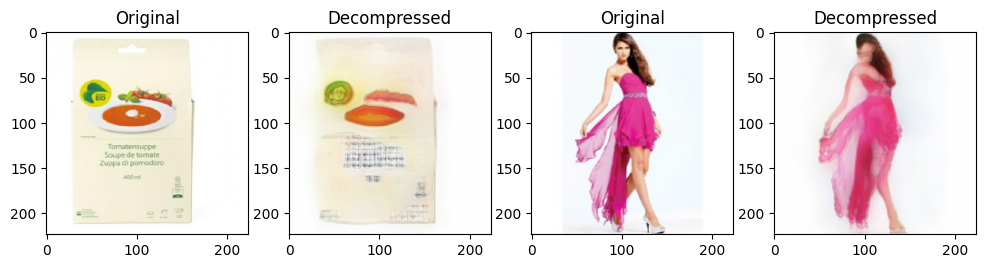

Validation: MSE: 0.013428613815052682, PSNR: 19.886291650978915, Entropy: 5.170094160286777, Perceptual: 1.5720018547701549
Trashed 35105 objects
Epoch 4 of 5. Total time: 2613.1703119277954


Training:   0%|          | 0/1656 [00:00<?, ?it/s]

Train comparisson:


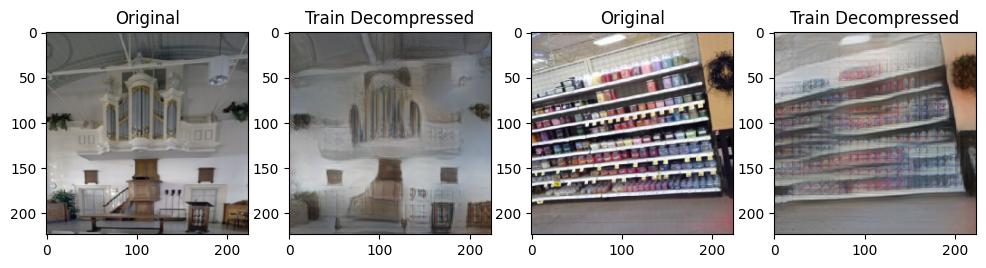

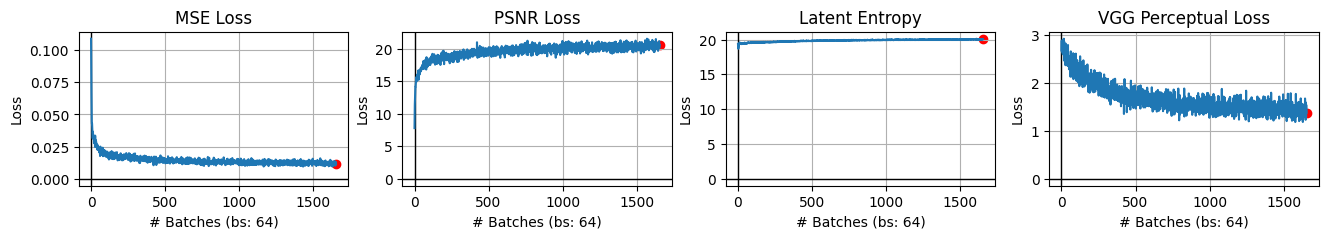

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


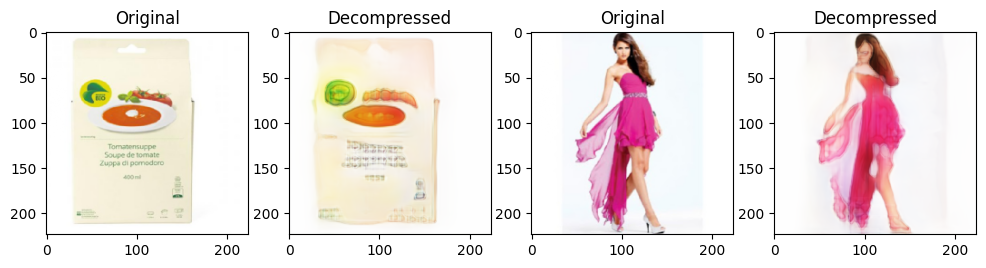

Validation: MSE: 0.01258288596543562, PSNR: 20.05655614094562, Entropy: 5.313897785508489, Perceptual: 1.463550212297095
Trashed 35130 objects
Epoch 5 of 5. Total time: 3485.4629983901978


Training:   0%|          | 0/1656 [00:00<?, ?it/s]

Train comparisson:


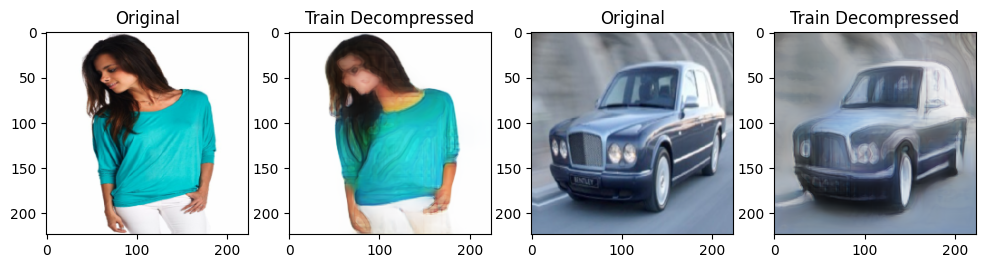

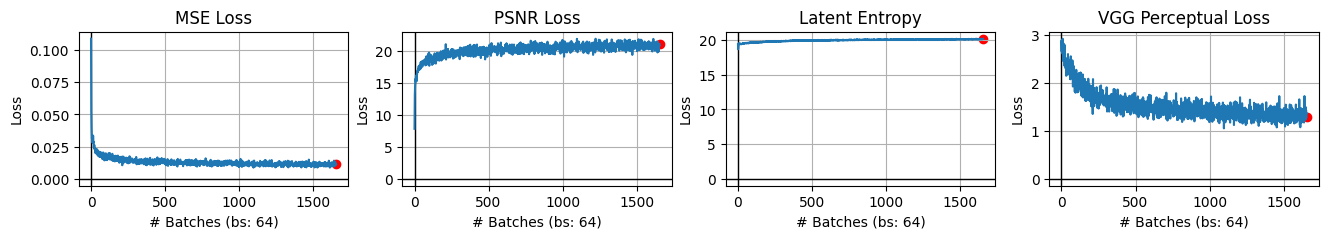

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


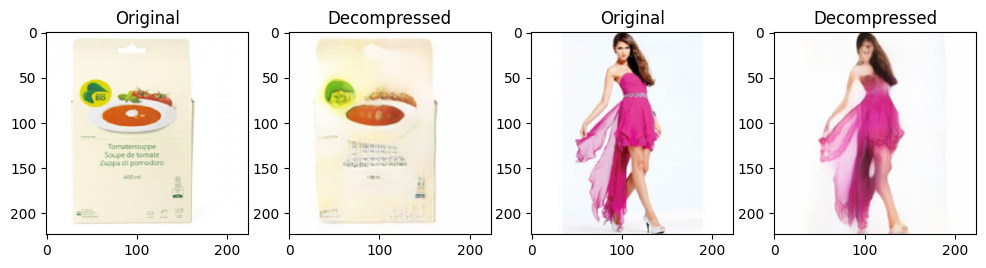

Validation: MSE: 0.01135308968284762, PSNR: 20.63304505405656, Entropy: 5.4590764183595955, Perceptual: 1.3397849364453052


In [ ]:
train_loop(model, train_quantization, valid_quantization, offset=0, epochs=5, dataloader=dataloader, optimizer=adam_optim)

In [42]:
save_model(model, "./", "L3_resnet50_full130k", 6, 3, 0.006, adam_optim)

In [ ]:
def test_image(paths: list[str]):
  _, axs = plt.subplots(len(paths), 2, figsize=(6, 3 * len(paths)))

  for i, path in enumerate(paths):
    test = torchvision.io.read_image(path).unsqueeze(0).to(torch.float32) / 256.0
    model.eval()

    print(f"{path}: Original shape: {list(test.shape[1:])}")

    test = test.to(device)

    intermediate = model.encode(test)
    intermediate = valid_quantization.forward(intermediate)

    print(f"{path}: Intermediate form: {list(intermediate.shape[1:])}")

    intermediate = valid_quantization.backward(intermediate)
    result = model.decode(intermediate)

    axs[i][0].imshow(test[0].detach().cpu().permute(1, 2, 0).numpy())
    axs[i][0].set_title("Original")
    axs[i][1].imshow(result[0].detach().cpu().permute(1, 2, 0).numpy())
    axs[i][1].set_title("Decompressed")

  plt.show()

test_images/baboon.png: Original shape: [3, 512, 512]
test_images/baboon.png: Intermediate form: [1024, 16, 16]
test_images/lena.png: Original shape: [3, 512, 512]
test_images/lena.png: Intermediate form: [1024, 16, 16]
test_images/peppers.png: Original shape: [3, 512, 512]
test_images/peppers.png: Intermediate form: [1024, 16, 16]


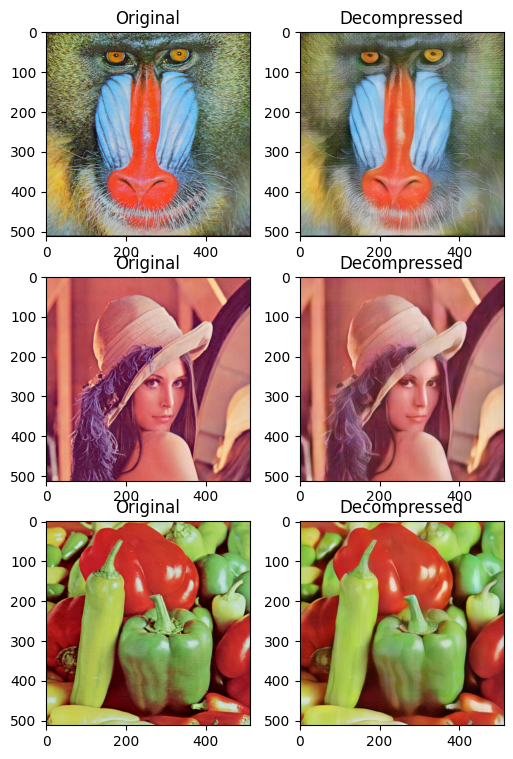

In [44]:
test_image(["test_images/baboon.png", "test_images/lena.png", "test_images/peppers.png"])

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [47]:
!cp /content/L3_resnet50_full130k_model_9_l_0,006.pth /content/gdrive/MyDrive/InfoTheory_Weights/

Training:   0%|          | 0/1656 [00:00<?, ?it/s]

Train comparisson:


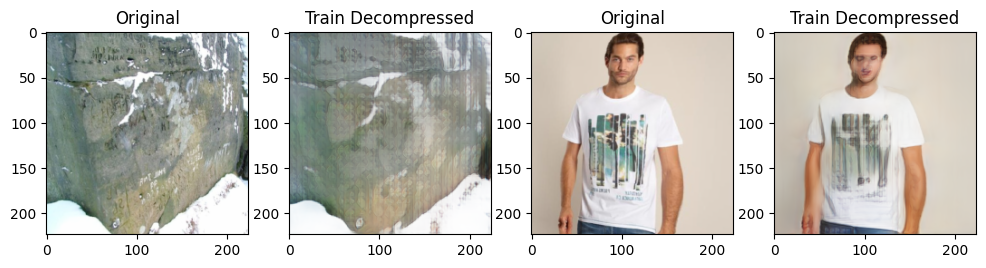

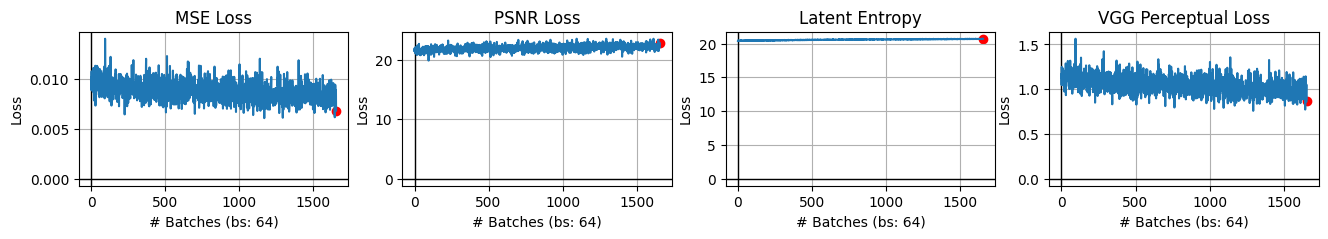

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


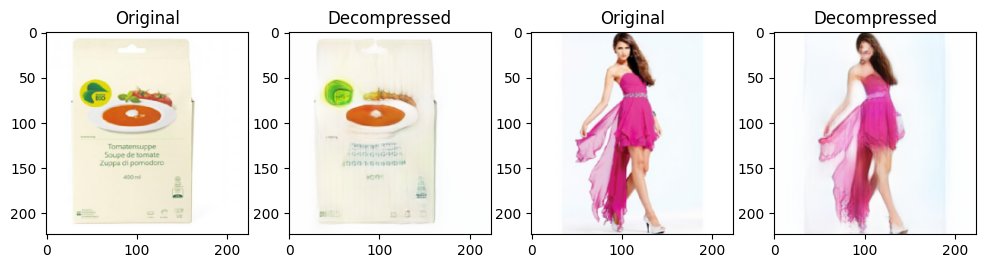

KeyboardInterrupt: ignored

In [40]:
train_loop(model, train_quantization, valid_quantization, offset=9, epochs=5, dataloader=dataloader, optimizer=adam_optim)

Training:   0%|          | 0/1656 [00:00<?, ?it/s]

Train comparisson:


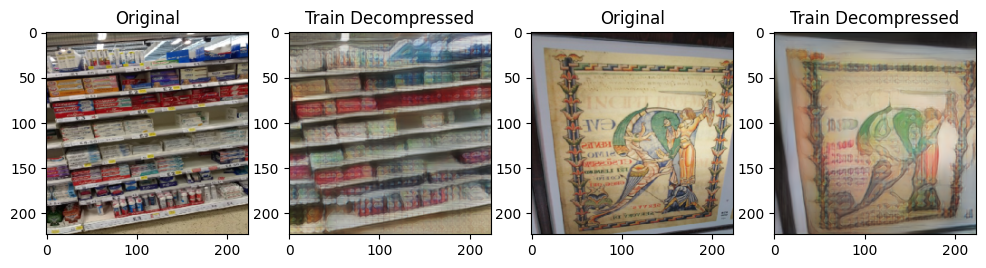

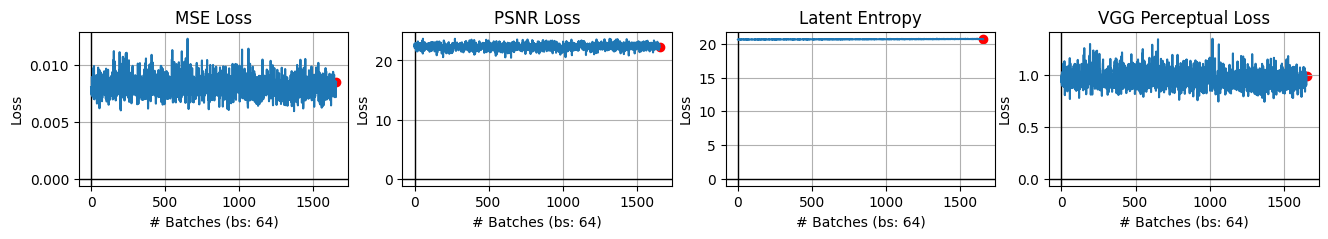

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


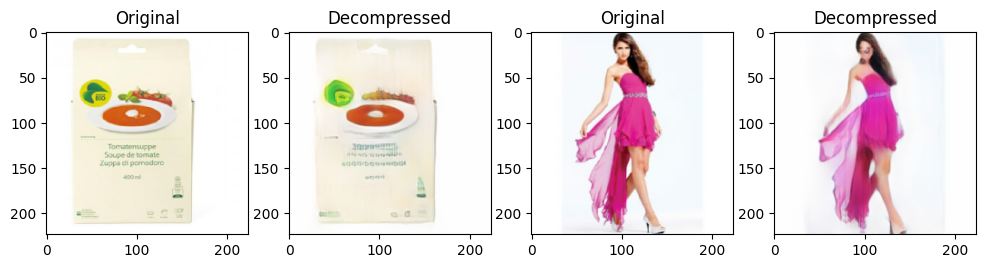

Validation: MSE: 0.008495183062391828, PSNR: 22.040302883286074, Entropy: 6.197402669148273, Perceptual: 1.0063333614763008


In [48]:
train_loop(model, train_quantization, valid_quantization, offset=9, epochs=1, dataloader=dataloader, optimizer=adam_optim)

Training:   0%|          | 0/1656 [00:00<?, ?it/s]

Train comparisson:


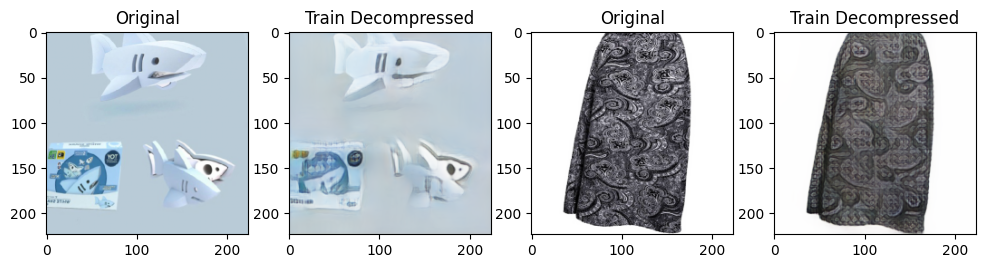

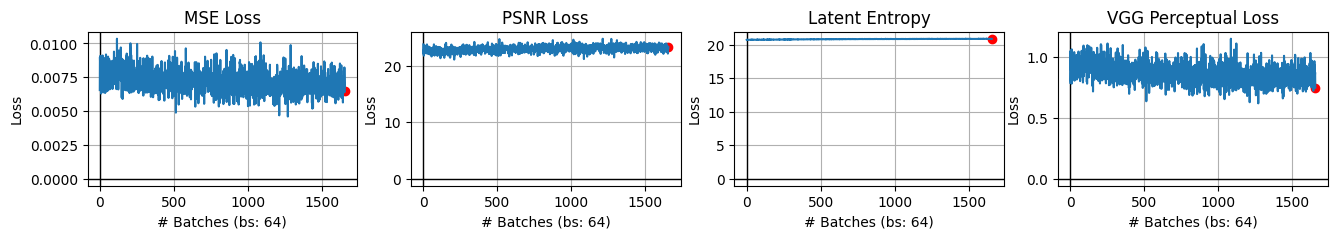

Validation:   0%|          | 0/415 [00:00<?, ?it/s]

Validation comparisson:


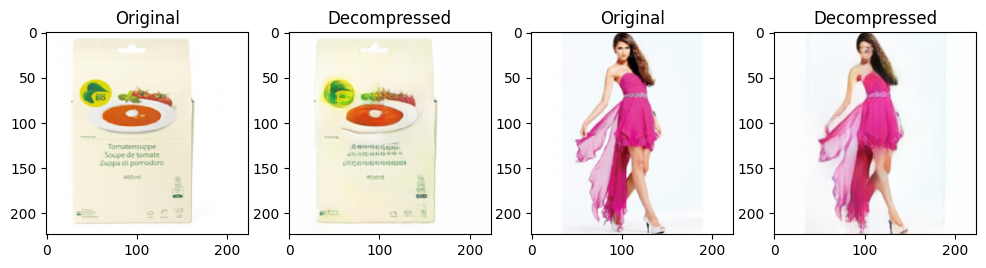

Validation: MSE: 0.00764733593664076, PSNR: 22.625928575446807, Entropy: 6.365913628957358, Perceptual: 0.8790608227971088


In [49]:
train_loop(model, train_quantization, valid_quantization, offset=10, epochs=4, dataloader=dataloader, optimizer=adam_optim)

In [50]:
save_model(model, "./", "L3_resnet50_full130k", 10, 4, 0.006, adam_optim)

In [51]:
!cp /content/L3_resnet50_full130k_model_14_l_0,006.pth /content/gdrive/MyDrive/InfoTheory_Weights/